### data analyis code file

link - https://github.com/nasirudeenraheem/Analytics-Olympiad-2022/blob/main/Data%20Analysis_Part-1.ipynb

In [15]:
import pandas as pd
import numpy as np

In [16]:
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

In [18]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [19]:
train['OUTCOME'].value_counts(normalize=True)

0.0    0.577352
1.0    0.422648
Name: OUTCOME, dtype: float64

In [20]:
print(train.shape)
print(test.shape)

(105000, 18)
(45000, 17)


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

In [22]:
#train = train.drop('ID', axis=1)
#test = test.drop('ID', axis=1)

In [23]:
age_group = {'65+':4, '40-64':3, '26-39':2 ,'16-25':1}
de_group = {'30y+':4, '20-29y':3,'10-19y':2,'0-9y':1}
edu_group = {'university':3, 'high school':2, 'none':1}
income_group = {'upper class':4, 'working class':3,'middle class':2, 'poverty':1}
vh_group = {'after 2015':2, 'before 2015':1}

In [24]:
train['AGE'] = train['AGE'].map(age_group)
test['AGE'] = test['AGE'].map(age_group)

train['DRIVING_EXPERIENCE'] = train['DRIVING_EXPERIENCE'].map(de_group)
test['DRIVING_EXPERIENCE'] = test['DRIVING_EXPERIENCE'].map(de_group)

train['EDUCATION'] = train['EDUCATION'].map(edu_group)
test['EDUCATION'] = test['EDUCATION'].map(edu_group)

train['INCOME'] = train['INCOME'].map(income_group)
test['INCOME'] = test['INCOME'].map(income_group)

train['VEHICLE_YEAR'] = train['VEHICLE_YEAR'].map(vh_group)
test['VEHICLE_YEAR'] = test['VEHICLE_YEAR'].map(vh_group)

In [25]:
train.select_dtypes(include='object').columns

Index(['GENDER', 'TYPE_OF_VEHICLE'], dtype='object')

In [26]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

In [27]:
for col in train.select_dtypes('O').columns:
  train[col] = lb.fit_transform(train[col])
  test[col] = lb.fit_transform(test[col])

### Feature Engineering

In [28]:
train['pc_count'] = train['POSTAL_CODE'].map(train['POSTAL_CODE'].value_counts().to_dict())
test['pc_count'] = test['POSTAL_CODE'].map(test['POSTAL_CODE'].value_counts().to_dict())

train['am_count'] = train['ANNUAL_MILEAGE'].map(train['ANNUAL_MILEAGE'].value_counts().to_dict())
test['am_count'] = test['ANNUAL_MILEAGE'].map(test['ANNUAL_MILEAGE'].value_counts().to_dict())

train['am_bin'] = pd.qcut(train['ANNUAL_MILEAGE'], 5, labels=[0,1,2,3,4]).astype(int)
test['am_bin'] = pd.qcut(test['ANNUAL_MILEAGE'], 5, labels=[0,1,2,3,4]).astype(int)

## Modelling

In [29]:
X = train.drop('OUTCOME', axis=1)
y = train['OUTCOME']

In [30]:
from sklearn.metrics import log_loss
errcb=[]
y_pred_totcb=[]
from sklearn.model_selection import StratifiedKFold
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model= CatBoostClassifier(loss_function='Logloss')
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100)
    preds=model.predict_proba(X_test)[:, 1]
    print("err: ",log_loss(y_test,preds))
    errcb.append(log_loss(y_test,preds))
    p = model.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

Learning rate set to 0.094669
0:	learn: 0.6909057	test: 0.6909184	test1: 0.6909944	best: 0.6909944 (0)	total: 77.2ms	remaining: 1m 17s
100:	learn: 0.6749011	test: 0.6749779	test1: 0.6812569	best: 0.6811434 (32)	total: 881ms	remaining: 7.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811434463
bestIteration = 32

Shrink model to first 33 iterations.
err:  0.6811434463118324
Learning rate set to 0.094669
0:	learn: 0.6909188	test: 0.6909288	test1: 0.6909891	best: 0.6909891 (0)	total: 8.15ms	remaining: 8.14s
100:	learn: 0.6747646	test: 0.6748415	test1: 0.6813984	best: 0.6811606 (25)	total: 816ms	remaining: 7.26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.681160619
bestIteration = 25

Shrink model to first 26 iterations.
err:  0.6811606189732459
Learning rate set to 0.094669
0:	learn: 0.6909238	test: 0.6909342	test1: 0.6909625	best: 0.6909625 (0)	total: 6.26ms	remaining: 6.25s
100:	learn: 0.6743871	test: 0.6744627	test1: 0.6815335	best: 0

In [31]:
print(np.mean(errcb))
print(np.std(errcb))

0.6810971070644983
9.896812362100656e-05


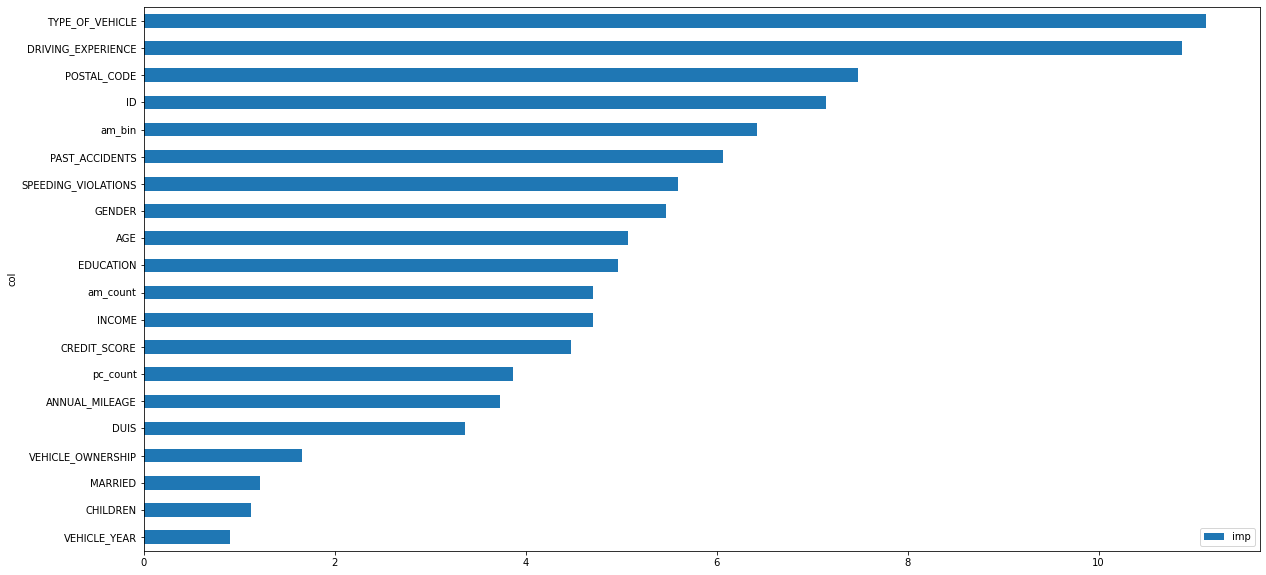

In [32]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))   

In [33]:
prediction = pd.DataFrame(np.mean(y_pred_totcb, 0), columns=['OUTCOME'])

In [34]:
prediction['OUTCOME'].describe()

count    45000.000000
mean         0.424952
std          0.008928
min          0.352901
25%          0.419199
50%          0.424807
75%          0.430477
max          0.495088
Name: OUTCOME, dtype: float64

In [35]:
prediction['OUTCOME'] = prediction['OUTCOME'].round(2)

In [36]:
prediction.to_csv('final2.csv', index=False)

### Model interpretability using shapely values

In [37]:
import shap

In [38]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

### Bar-plot of the model

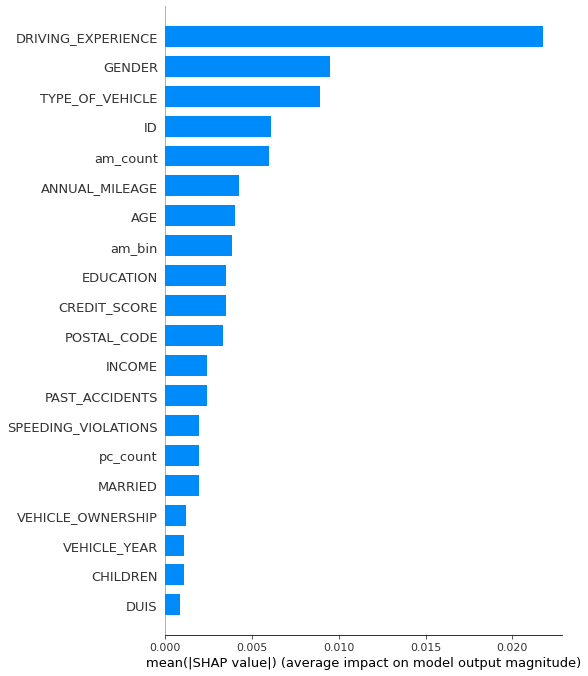

In [39]:
shap_values = shap.TreeExplainer(model).shap_values(test)
shap.summary_plot(shap_values, test, plot_type="bar")

The shapely values picks the following features as the Top 5

* Driving Experience changing the prediction of the outcome on average of 3%

* Gender changing the prediction of the outcome on average of 1.3%

* Type of Vehicle changing the prediction of the outcome on average of 1.2

* ID changing the prediction of the outcome on average of 1%

* Annunal mileage bin changing the prediction of the outcome on average of 1%

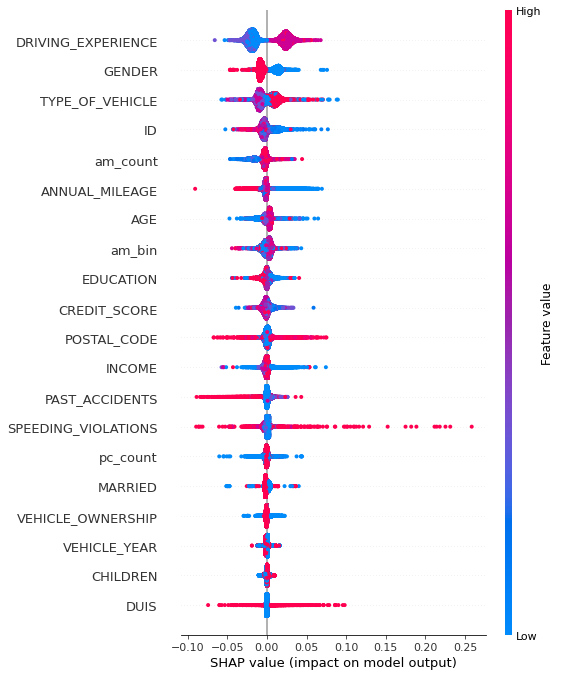

In [40]:
shap.summary_plot(shap_values, test)

**Making a decision**

* A higher level of driving experience indicates that the claim must be accepted.

* When a Gender is female, it indicates that the claim is accepted; when it is male, it indicates that the claim is rejected. (The gender bias in algorithms must be addressed.)

* Those claiming less annual mileage must be accepted.